In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

In [2]:
## Estimation of Fuel Cell System price:
truck_cost = 3E5
fuel_cell_cost = 1E5
rated_power = 275

truck_specific = truck_cost/rated_power
fc_specific = fuel_cell_cost/rated_power

print("Truck cost ",truck_specific, "($/kW)")
print("Cell cost ",fc_specific, "($/kW)")

Truck cost  1090.909090909091 ($/kW)
Cell cost  363.6363636363636 ($/kW)


### Constants

In [3]:
F = 96485 # C / mol
ne_H2 = 2 # mol e / mol H
m_H2 = 2 # g/mol
g_to_kg = 1000
G0 = 237000 # J / mol
H0 = 285000 # J / mol
S0 = 163 # J / mol-K
V_to_eff = 26.8 # conversion factor for hydrogen at STP?

In [4]:
### Model assumptions = = = =
## Comment out the variable functions

#Operating
ELECTRIC = 0.10 # $/kWh
CAPACITY = 0.2 # Shouldn't be above 0.33 per grid modeling results, and likely less..

# Finances
IRR = 0.10 # fractional rate
INFLATION = 0.019 # fractional rate

# System Durability
replace_rate = 10 # Based on a capacity of 0.3 and a 25,0000 hour life (https://www.hydrogen.energy.gov/pdfs/review20/fc163_james_2020_o.pdf)
voltage_drift = 5E-6 # V/h
stack_replacement = 0.5 # fraction

MAXCELLV = 0.75
MINEFFICIENCY = MAXCELLV - voltage_drift * 8760 * CAPACITY * 10 

### Cash flow set up

In [5]:
## Balance of plant
# Reference: https://www.hydrogen.energy.gov/pdfs/review20/fc163_james_2020_o.pdf

## Stack model
nameplate_capacity = 1E4  # 10,000 kW (10 MW)
max_year = 20

def system_model(fc_stack_cost, SHOWCOSTS=False):
    
    #====Model inputs
    balance_specific_cost = 50 # $/kW
     ##Reference: 2021 DOE Hydrogen and Fuel Cells Program Review Presentation
    balance_system_cost = balance_specific_cost * nameplate_capacity
    
    hydrogen_stored = 1E6 / (33.4 * MINEFFICIENCY) #10,000 kW * 100 hours / (33.4 * EFFICIENCY kWh/kg)
    storage_specific_capital = 72 # $/kg stored https://www.hydrogen.energy.gov/pdfs/review19/st001_ahluwalia_2019_o.pdf
    #storage capital can be lower for salt-caverns, for example
    storage_capital = storage_specific_capital * hydrogen_stored
    
    ## Estimated as ~4X LDV BoP cost
    ## See report: "Mass Production Cost Estimation of Direct H2 PEM Fuel...
    ## ... Cell Systems for Transportation Applications: 2018 Update"
    
    system_cost = fc_stack_cost*nameplate_capacity + storage_capital + balance_system_cost
    #====
    
    
    if SHOWCOSTS:
        print()
        print("Total system cost is ${0:.2f} million".format(system_cost/1e6))
        print("Stack:  ${0:.2f} million".format(fc_stack_cost*nameplate_capacity/1e6))
        print("Storage: ${0:.2f} million".format(storage_capital/1e6))
        print("Mechanical: ${0:.2f} million".format(balance_system_cost/1e6))

    return system_cost

In [6]:
system_model(50, SHOWCOSTS=True)


Total system cost is $4.25 million
Stack:  $0.50 million
Storage: $3.25 million
Mechanical: $0.50 million


4254360.843530331

### Calculate LCOH

In [7]:
def NPV_calc(HYDROGEN, ELECTRIC, stack_cost, SHOWTABLE = False):
    
   #Scheduled cash flow
    CashFlow = pd.DataFrame({'Years':[],'Stack Life':[],'Inflation Year':[],
                            'Stack Eff':[], 'Hydrogen Sales':[],'Replacement Costs':[],'Operating Costs':[],
                            'Net Cash Flow':[],'Discounted Flow':[]})
    
    system_cost=system_model(stack_cost)

    ## Initialize variables
    year = [1]
    stacklife = [0]
    inflationyear = [1]
    stackeff = [0]
    hydrogensales = [0]
    replacement_costs = [0]
    operating_costs = [0]
    net_cash = [-system_cost]
    discounted_cash = [net_cash[-1]/(1+IRR)**year[-1]]

    for x in range(2,max_year+2):
        year.append(x)
        inflationyear.append((1+INFLATION)**x)

        #Hydrogen sales
        hydrogensales.append(ELECTRIC*nameplate_capacity*8760*CAPACITY) # [$/kg] * [kg/h] * [h/year] * percent
        hydrogensales[-1] = hydrogensales[-1]*inflationyear[-1]

        #Stacklife counting
        if stacklife[-1] < replace_rate and year[-1] != max_year: # Don't replace stack in the last year of life
            stacklife.append(stacklife[-1]+1)
        else:
            stacklife.append(1)

        #Maintenance cost are 0.5% system cost per year + stack replacement
        replacement_costs.append(stack_replacement*stack_cost*(stacklife[-1]==replace_rate) + 0.005*system_cost)
        replacement_costs[-1] = replacement_costs[-1]*inflationyear[-1]

        #Stack efficiency is the average of the beginning and end of year efficiency
        stackeff.append(V_to_eff*(MAXCELLV - voltage_drift*8760*CAPACITY*(stacklife[-1]+stacklife[-1]-1) / 2) )

        #Operating costs are assumed to be dominated by electricity prices
        operating_costs.append(HYDROGEN*nameplate_capacity*8760*CAPACITY/stackeff[-1]) # [$/kWh] * [kWh/kg] * [kg/h] * [h/year] * percent
        operating_costs[-1] = operating_costs[-1]*inflationyear[-1]

        #Net cash flow = Sales - replacement - operating costs
        net_cash.append(hydrogensales[-1] - operating_costs[-1] - replacement_costs[-1])

        #Discounted cash flow = net cash flow / (1+IRR)^year
        discounted_cash.append(net_cash[-1]/(1+IRR)**year[-1])

    CashFlow['Years'] = year
    CashFlow['Stack Life'] = stacklife
    CashFlow['Inflation Year'] = inflationyear
    CashFlow['Stack Eff'] = stackeff
    CashFlow['Hydrogen Sales'] = hydrogensales
    CashFlow['Replacement Costs'] = replacement_costs
    CashFlow['Operating Costs'] = operating_costs
    CashFlow['Net Cash Flow'] = net_cash
    CashFlow['Discounted Flow'] = discounted_cash
    
    if SHOWTABLE:
        return CashFlow
    else:
        return sum(CashFlow['Discounted Flow'])


In [8]:
# Single table check:
stacks = 200
NPV_calc(HYDROGEN=3, ELECTRIC=0.15, stack_cost=stacks, SHOWTABLE=True)

,Years,Stack Life,Inflation Year,Stack Eff,Hydrogen Sales,Replacement Costs,Operating Costs,Net Cash Flow,Discounted Flow
0,1,0,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,-5.754361e+06,-5.231237e+06
1,2,1,1.038361,19.982616,2.728813e+06,29875.519399,2.731187e+06,-3.224947e+04,-2.665245e+04
2,3,2,1.058090,19.747848,2.780660e+06,30443.154268,2.816165e+06,-6.594824e+04,-4.954789e+04
3,4,3,1.078194,19.513080,2.833493e+06,31021.574199,2.904198e+06,-1.017272e+05,-6.948104e+04
4,5,4,1.098679,19.278312,2.887329e+06,31610.984109,2.995417e+06,-1.396988e+05,-8.674197e+04
5,6,5,1.119554,19.043544,2.942188e+06,32211.592807,3.089959e+06,-1.799821e+05,-1.015952e+05
6,7,6,1.140826,18.808776,2.998090e+06,32823.613070,3.187969e+06,-2.227029e+05,-1.142818e+05
7,8,7,1.162501,18.574008,3.055054e+06,33447.261718,3.289601e+06,-2.679945e+05,-1.250214e+05
8,9,8,1.184589,18.339240,3.113100e+06,34082.759691,3.395015e+06,-3.159980e+05,-1.340140e+05
9,10,9,1.207096,18.104472,3.172249e+06,34730.332125,3.504381e+06,-3.668630e+05,-1.414416e+05


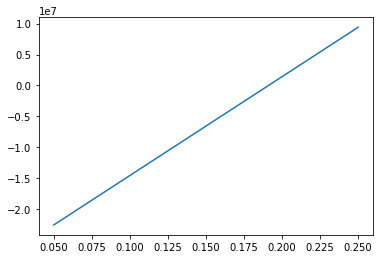

In [9]:
# Plot vs Electricity

prices = np.linspace(0.05,0.25,10)
npv_result = []
for price in prices:
    npv_result.append(NPV_calc(HYDROGEN=3, ELECTRIC=price, stack_cost=200))
    
plt.plot(prices,npv_result)

In [10]:
def LCOE(cost_of_hydrogen,stack_cost):
  
    low_price = 0.01
    high_price = 0.25
    low_val = NPV_calc(HYDROGEN=cost_of_hydrogen,ELECTRIC=low_price,stack_cost=stack_cost)
    high_val = NPV_calc(HYDROGEN=cost_of_hydrogen, ELECTRIC=high_price,stack_cost=stack_cost)
    
    slope = (high_price - low_price)/(high_val - low_val)
    
#     print()
#     print(" = = = = = = = = = ")
#     print("Hydrogen price = ${0:0.2f}/kWh".format(cost_of_hydrogen))
#     print("Capacity factor = {0:0.2f}".format(CAPACITY))
#     print("Levelized cost of electricity ($/kWh) is... ")
    
    return high_price - high_val*slope

### Iterate across LCOH vs model assumptions

Iteratively set up model + build NPV function before running LCOH function to calculate LCOH

In [11]:
LCOE(1,25)

0.07615613997239745

In [12]:
## Set up a mesh grid for desired variables
Hs = np.linspace(0.5,6,15)
Stacks = np.logspace(1,3,25)
XX,YY = np.meshgrid(Hs,Stacks) # syntax is columns, rows
rs, cs = np.shape(XX)
Z = np.zeros((rs,cs))

for row in range(0,len(Stacks)):
    for col in range(0,len(Hs)):
            H = XX[row,col]
            stack = YY[row,col]
            Z[row,col] = LCOE(cost_of_hydrogen=H, stack_cost=stack)

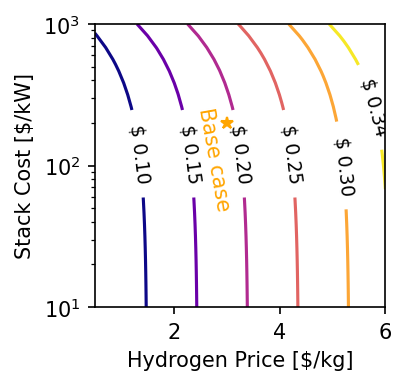

In [13]:
fig, ax = plt.subplots(figsize=(2.5,2.5))
CS = ax.contour(XX, YY, Z, [0.10, 0.15, 0.20, 0.25, 0.30, 0.34], cmap='plasma', vmin=0.10, vmax=0.35)
ax.set_xlabel('Hydrogen Price [$/kg]')
ax.set_ylabel('Stack Cost [\$/kW]')
ax.plot(3,200,'*',color='orange')
ax.text(2.4,50,'Base case',color='orange', rotation=-80)
ax.set_yscale('log')
ax.clabel(CS, inline=True, fontsize=9, colors='k', fmt='$ %1.2f')
plt.gcf().set_dpi(150)

In [14]:
## As seen with electrolyzers, hydrogen costs dominate power costs (not capital)